In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from SPARQLWrapper import SPARQLWrapper, JSON
import numpy as np

In [2]:
endpoint_url = "https://query.wikidata.org/sparql"

query = '''
PREFIX wd:   <http://www.wikidata.org/entity/>
PREFIX wdt:  <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?person ?personLabel ?team ?teamLabel
WHERE {
  ?person wdt:P106 wd:Q10841764 ;
          wdt:P54 ?team .
  OPTIONAL { ?person rdfs:label ?personLabel . FILTER(LANG(?personLabel) = "en") }
  OPTIONAL { ?team rdfs:label ?teamLabel . FILTER(LANG(?teamLabel) = "en") }
}
LIMIT 10000
'''

In [3]:
def get_sparql_results(endpoint_url, query):
    sparql = SPARQLWrapper(endpoint_url)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    rows = []
    for res in results["results"]["bindings"]:
        rows.append({
            "person": res.get("person", {}).get("value", ""),
            "personLabel": res.get("personLabel", {}).get("value", ""),
            "team": res.get("team", {}).get("value", ""),
            "teamLabel": res.get("teamLabel", {}).get("value", "")
        })
    return pd.DataFrame(rows)

In [4]:
df = get_sparql_results(endpoint_url, query)
df.head()

,person,personLabel,team,teamLabel
0,http://www.wikidata.org/entity/Q171716,Huub Rothengatter,http://www.wikidata.org/entity/Q144823,Zakspeed
1,http://www.wikidata.org/entity/Q78489,Niki Lauda,http://www.wikidata.org/entity/Q169898,Scuderia Ferrari
2,http://www.wikidata.org/entity/Q78502,Gerhard Berger,http://www.wikidata.org/entity/Q169898,Scuderia Ferrari
3,http://www.wikidata.org/entity/Q171723,Cliff Allison,http://www.wikidata.org/entity/Q169898,Scuderia Ferrari
4,http://www.wikidata.org/entity/Q171933,Eugenio Castellotti,http://www.wikidata.org/entity/Q169898,Scuderia Ferrari


In [5]:
B = nx.Graph()
B.add_nodes_from(df["personLabel"], bipartite=0, type="pilote")
B.add_nodes_from(df["teamLabel"], bipartite=1, type="team")
edges = list(zip(df["personLabel"], df["teamLabel"]))
B.add_edges_from(edges)

print("Nombre de nœuds :", B.number_of_nodes())
print("Nombre d'arêtes :", B.number_of_edges())

Nombre de nœuds : 343
Nombre d'arêtes : 451


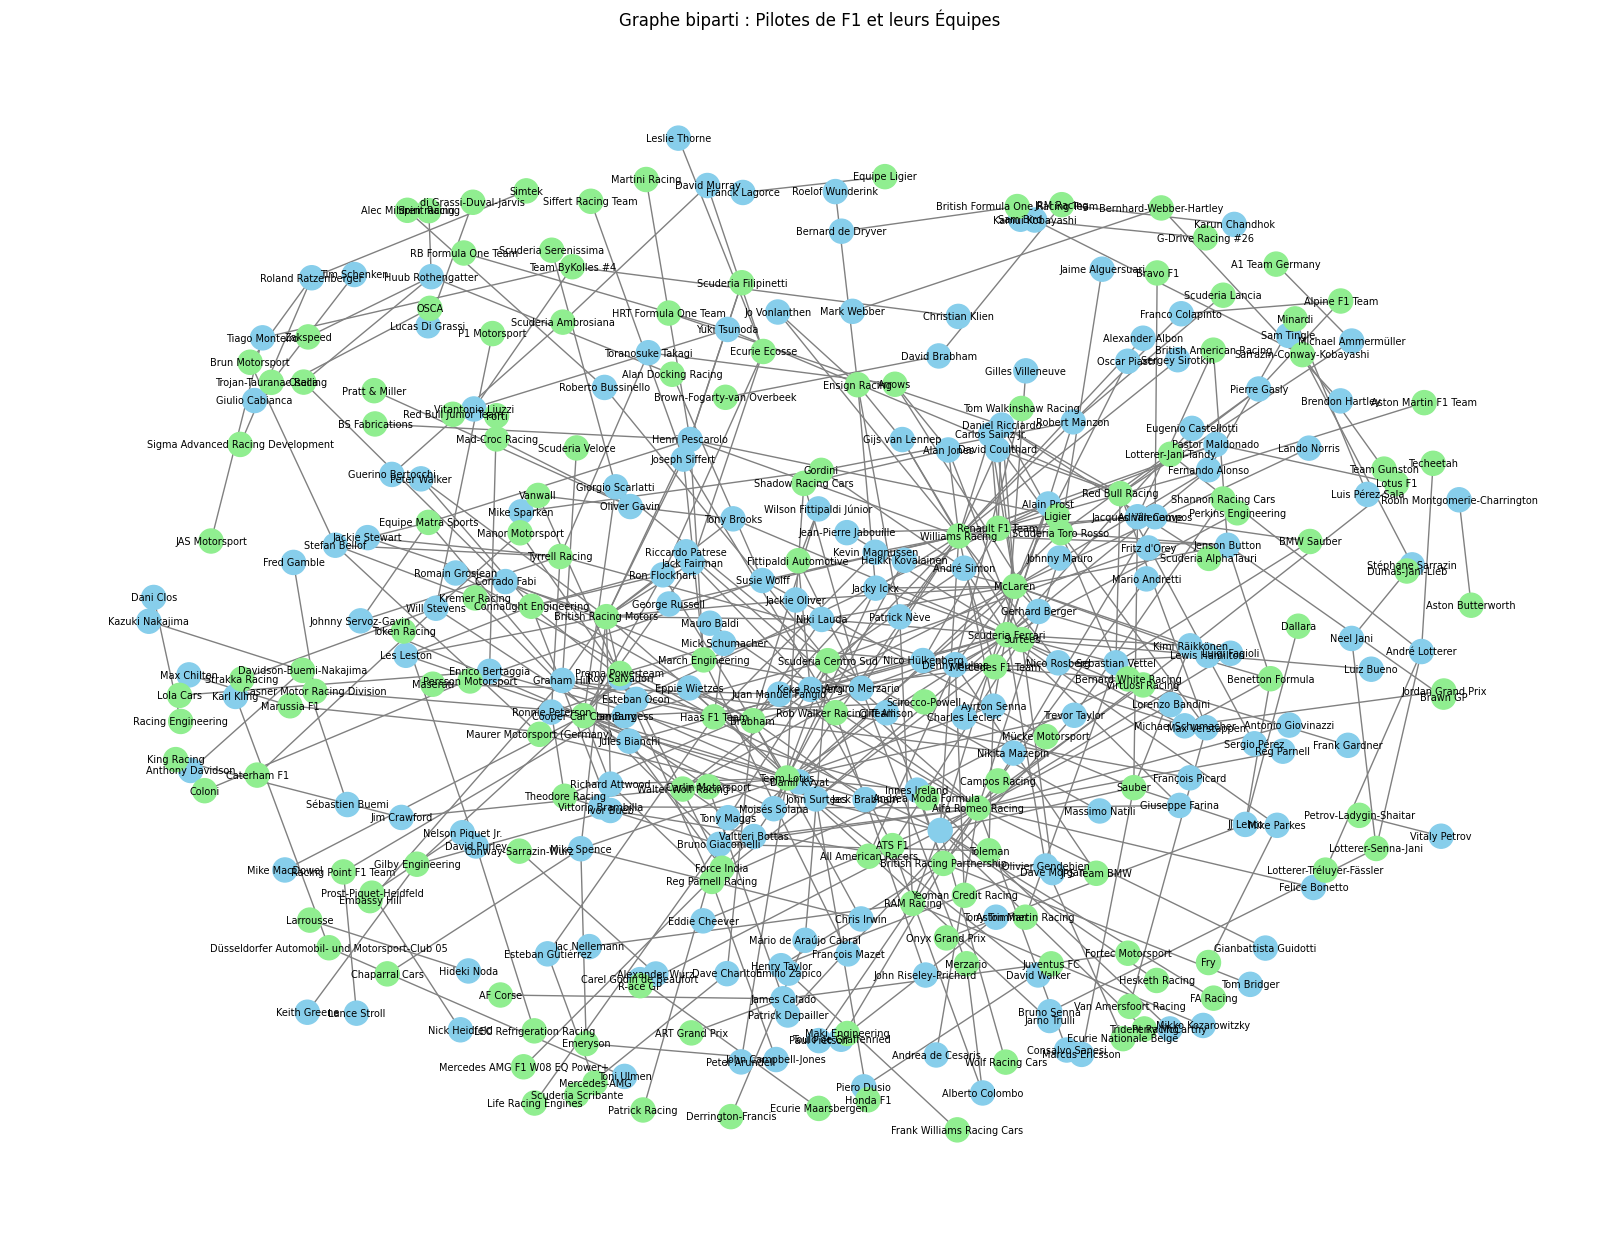

In [8]:
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(B, k=0.3, seed=42)
colors = ['skyblue' if B.nodes[n]['type'] == 'pilote' else 'lightgreen' for n in B.nodes()]
nx.draw(B, pos, with_labels=True, node_color=colors, node_size=300, font_size=7, edge_color='gray')
plt.title("Graphe biparti : Pilotes de F1 et leurs Équipes")
plt.axis('off')
plt.show()



In [9]:
pilotes = {n for n, d in B.nodes(data=True) if d['type'] == 'pilote'}
teams = set(B) - pilotes

deg_pilotes = np.mean([B.degree(n) for n in pilotes])
deg_teams = np.mean([B.degree(n) for n in teams])

print(f"Degré moyen des pilotes : {deg_pilotes:.2f}")
print(f"Degré moyen des équipes : {deg_teams:.2f}")

Degré moyen des pilotes : 2.42
Degré moyen des équipes : 2.87


In [10]:
top_teams = sorted([(n, B.degree(n)) for n in teams], key=lambda x: x[1], reverse=True)[:10]
print("Équipes avec le plus de pilotes :")
for team, deg in top_teams:
    print(f"{team}: {deg} pilotes")

top_pilotes = sorted([(n, B.degree(n)) for n in pilotes], key=lambda x: x[1], reverse=True)[:10]
print("\nPilotes avec le plus d'équipes :")
for pilote, deg in top_pilotes:
    print(f"{pilote}: {deg} équipes")

Équipes avec le plus de pilotes :
Williams Racing: 23 pilotes
Scuderia Ferrari: 23 pilotes
Alfa Romeo Racing: 23 pilotes
McLaren: 20 pilotes
Team Lotus: 19 pilotes
British Racing Motors: 15 pilotes
Cooper Car Company: 13 pilotes
Renault F1 Team: 11 pilotes
Scuderia Centro Sud: 10 pilotes
Brabham: 10 pilotes

Pilotes avec le plus d'équipes :
: 13 équipes
Denny Hulme: 9 équipes
Henri Pescarolo: 8 équipes
Graham Hill: 7 équipes
Bruno Giacomelli: 7 équipes
Arturo Merzario: 7 équipes
John Surtees: 7 équipes
Jacky Ickx: 6 équipes
Roy Salvadori: 6 équipes
Keke Rosberg: 6 équipes
